# Import data and libs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/MyDrive/Colab Notebooks/DL/HW3/'

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/DL/HW3/'
/content/drive/MyDrive/Colab Notebooks/DL/HW3


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer #
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding, concatenate 
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# nltk
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
traindf = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
traindf.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
testdf = pd.read_csv("data/testdata.manual.2009.06.14.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')

testdf.head()

,polarity,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


## Update polarity
`polarity` column:
`0` : negative, `4` : positive

Change that to `0` and `1`

In [ ]:
traindf.polarity.value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

In [ ]:
testdf.polarity.value_counts()

4    182
0    177
2    139
Name: polarity, dtype: int64

In [ ]:
traindf.polarity = traindf.polarity.replace({0: 0, 4: 1})
traindf.polarity.value_counts()

1    800000
0    800000
Name: polarity, dtype: int64

In [ ]:
testdf = testdf[testdf.polarity != 2]
testdf.polarity = testdf.polarity.replace({0: 0, 4: 1})
testdf.polarity.value_counts()

1    182
0    177
Name: polarity, dtype: int64

In [ ]:
traindf = traindf.drop(columns=['id', 'date', 'query', 'user'])
testdf = testdf.drop(columns=['id', 'date', 'query', 'user'])

In [ ]:
traindf

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


# Preprocessing

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english") # Snowball Stemmer – NLP

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|#\S+|https?:\S+|http?:\S", ' ', str(text).lower()).strip() # Remove user ids, hashtags and links
    text = re.sub("[^A-Za-z0-9]+", ' ', str(text).lower()).strip()            # Remove special characters 
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
traindf.text = traindf.text.apply(lambda x: preprocess(x))
testdf.text = testdf.text.apply(lambda x: preprocess(x))

In [ ]:
traindf

,polarity,text
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see
...,...,...
1599995,1,woke school best feeling ever
1599996,1,thewdb com cool hear old walt interviews
1599997,1,ready mojo makeover ask details
1599998,1,happy 38th birthday boo alll time tupac amaru ...


In [ ]:
## Find length of longest tweet(for embedding)
length_of_the_tweets = traindf['text'].str.split("\\s+")

print(length_of_the_tweets)
print('Max number of words = ', length_of_the_tweets.str.len().max())
print('Index = ', length_of_the_tweets.str.len().idxmax())

0          [awww, bummer, shoulda, got, david, carr, thir...
1          [upset, update, facebook, texting, might, cry,...
2          [dived, many, times, ball, managed, save, 50, ...
3                    [whole, body, feels, itchy, like, fire]
4                                       [behaving, mad, see]
                                 ...                        
1599995                  [woke, school, best, feeling, ever]
1599996     [thewdb, com, cool, hear, old, walt, interviews]
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, 38th, birthday, boo, alll, time, tupac...
1599999                                              [happy]
Name: text, Length: 1600000, dtype: object
Max number of words =  50
Index =  1447652


In [ ]:
TRAIN_SIZE = 0.8
MAX_SEQUENCE_LENGTH = length_of_the_tweets.str.len().max() # 50

In [ ]:
train_data, valid_data = train_test_split(traindf, test_size=1-TRAIN_SIZE, random_state=7) 
test_data = testdf
print("Train Data size: ", len(train_data))
print("Valid Data size:  ", len(valid_data))
print("Test Data size:  ", len(test_data))

Train Data size:  1280000
Valid Data size:   320000
Test Data size:   359


In [ ]:
train_data

,polarity,text
23786,0,need friends
182699,0,im trying call impossible
476661,0,good pace going 3k 13 min missed 5k turn ended...
1181490,1,u gonna shows ny soon luv see u live
878773,1,hell yea get em tattoos ink free wish parents ...
...,...,...
839891,1,say anything amsterdam tom wrote plan come eur...
535030,0,wishing back nyc pals
573977,0,itunes store says quot download free updates q...
1238212,1,sunburnt british weather good times x


In [ ]:
train_data, valid_data = train_test_split(traindf, test_size=1-TRAIN_SIZE, random_state=7) 
test_data = testdf
print("Train Data size: ", len(train_data))
print("Valid Data size:  ", len(valid_data))
print("Test Data size:  ", len(test_data))

Train Data size:  1280000
Valid Data size:   320000
Test Data size:   359


In [ ]:
train_data.drop(train_data.tail(680000).index, inplace = True)

In [ ]:
train_data.drop(train_data.tail(1180000).index, inplace = True)

In [ ]:
valid_data.drop(valid_data.tail(310000).index, inplace = True)

In [ ]:
#train_data.drop(train_data.tail(500000).index, inplace = True)

In [ ]:
train_data

,polarity,text
23786,0,need friends
182699,0,im trying call impossible
476661,0,good pace going 3k 13 min missed 5k turn ended...
1181490,1,u gonna shows ny soon luv see u live
878773,1,hell yea get em tattoos ink free wish parents ...
...,...,...
731220,0,time miami almost din prime one 12 tonight goo...
971088,1,gyu kaku plus pedicure mom good way de stress
17383,0,kno got excited
1498932,1,careful make time 3rd 4th qtr


# Bert classifier


In [ ]:
!pip install -q -U tensorflow-text


In [ ]:
!pip install -q tf-models-official==2.4.0


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"), do_lower_case=True)
print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
text = tf.ragged.constant([encode_sentence(s) for s in tf.convert_to_tensor(train_data["text"])])

In [ ]:
print("train text shape:", text.shape.as_list())

train text shape: [100000, None]


In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*text.shape[0]
input_word_ids = tf.concat([cls, text], axis=-1)

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

In [ ]:
type_cls = tf.zeros_like(cls)
type_t1 = tf.zeros_like(text)
input_type_ids = tf.concat([type_cls, type_t1], axis=-1).to_tensor()

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(input_tensor, tokenizer):
  num_examples = len(input_tensor)
  
  text = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(input_tensor)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*text.shape[0]
  input_word_ids = tf.concat([cls, text], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(text)
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
x_train = bert_encode(tf.convert_to_tensor(train_data.text), tokenizer)
y_train = tf.convert_to_tensor(train_data.polarity)

x_valid = bert_encode(tf.convert_to_tensor(valid_data.text), tokenizer)
y_valid = tf.convert_to_tensor(valid_data.polarity)

x_test = bert_encode(tf.convert_to_tensor(test_data.text), tokenizer)
y_test  = tf.convert_to_tensor(test_data.polarity)

In [ ]:
for key, value in x_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'y_train shape: {y_train.shape}')

input_word_ids  shape: (100000, 55)
input_mask      shape: (100000, 55)
input_type_ids  shape: (100000, 55)
y_train shape: (100000,)


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=2)

In [ ]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
# Set up epochs and steps
epochs = 3
batch_size = 32

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
#optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

In [ ]:
metrics = tf.keras.metrics.BinaryAccuracy() #[tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.BinaryCrossentropy() #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = bert_classifier.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=32, epochs=epochs)

Epoch 1/3
3125/3125 [==============================] - 2159s 687ms/step - loss: 0.8883 - binary_accuracy: 0.7048 - val_loss: 0.5103 - val_binary_accuracy: 0.7693
Epoch 2/3
3125/3125 [==============================] - 2143s 686ms/step - loss: 0.5640 - binary_accuracy: 0.7285 - val_loss: 0.4825 - val_binary_accuracy: 0.7732
Epoch 3/3
3125/3125 [==============================] - 2142s 685ms/step - loss: 0.4998 - binary_accuracy: 0.7783 - val_loss: 0.4884 - val_binary_accuracy: 0.7790


In [ ]:
def plot_curves(history):
	# plot loss
	plt.title('Cross Entropy Loss')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')  
	plt.plot(history.history['loss'], label='train')
	plt.plot(history.history['val_loss'], label='valid')
	plt.legend() 
	plt.show()
	# plot accuracy
	plt.title('Classification Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')   
	plt.plot(history.history['binary_accuracy'], label='train')
	plt.plot(history.history['val_binary_accuracy'], label='valid')
	plt.legend()
	plt.show()

In [ ]:
def plot_confusion_matrix(y_test, y_prediction, class_names, Normalization=True):
  con = tf.math.confusion_matrix(labels=y_test, predictions=y_prediction, num_classes=2).numpy()
  df_cm = pd.DataFrame(con, index = [i for i in class_names], columns = [i for i in class_names])
  if Normalization == False:
    plt.figure(figsize = (6,6))
    sn.heatmap(df_cm, annot=True, fmt='.0f',annot_kws={"size": 9})
    plt.ylabel('Labels')
    plt.xlabel('Predictions')
    plt.title('Confusion Matrix')
  else:
    cmn = con.astype('float') / con.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cmn, index = [i for i in class_names], columns = [i for i in class_names])
    plt.figure(figsize = (6,6))
    sn.heatmap(df_cm, annot=True, fmt='.2f',annot_kws={"size": 9})
    plt.ylabel('Labels')
    plt.xlabel('Predictions')
    plt.title('Confusion Matrix')

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [ ]:
score = bert_classifier.evaluate(x_test, y_test, verbose=0)
print("Test loss:    ", score[0])
print("Test accuracy:", score[1],'\n')

# save model
bert_classifier.save('./models/bert.h5')

Test loss:     0.380722314119339
Test accuracy: 0.8384401202201843 



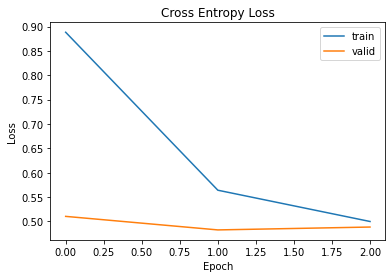

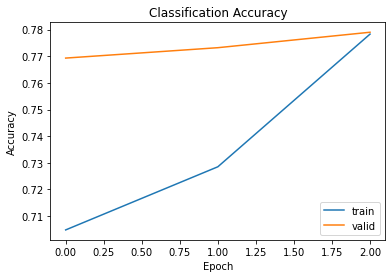

In [ ]:
plot_curves(history)

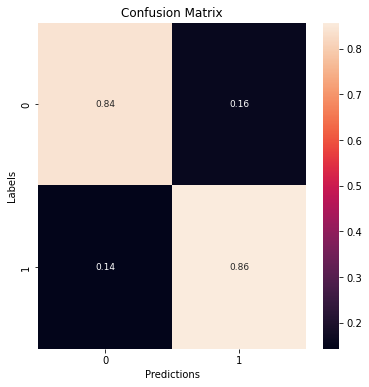

In [ ]:
model_out = bert_classifier.predict(x_test)
plot_confusion_matrix(y_test, tf.argmax(model_out, axis=1), [0,1])